<a href="https://colab.research.google.com/github/deepaksirohiwal/Deep_Learning_with_PyTorch/blob/main/cifar_10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(17)

In [ ]:
#setting the device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data transformation and augmentation


In [ ]:
# data transform and augmentation
stats=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # mean and std for each channel

train_transform=transforms.Compose(
    [
     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(*stats, inplace=True)]
)

valid_transform= transforms.Compose(
                [transforms.ToTensor(),
                transforms.Normalize(*stats)]
)

## Downloading data

Downloding images using torchvision datasets. We can use dataloader to retreive images in batches.

In [ ]:
batch_size=100
#downloading the images
train_data=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

test_data=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_transform)

#dataloader
train_loader=torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          )
test_loader=torch.utils.data.DataLoader(test_data,
                                        batch_size=batch_size,
                                        shuffle=True)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


Let's look at some of the sample images from training dataloader (train_loader).
To display the image we first need to denormalize them.

In [ ]:
def denormalize(images, means, stds):
  means=torch.tensor(means).reshape(1,3,1,1) # 1 X 3 X 1 X 1, for all three channels
  stds= torch.tensor(stds).reshape(1,3,1,1)
  return images * stds + means # opposite of the normalization


def show_image(dl):
  for images, labels in dl:
    print(images.shape)
    fig, ax=plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

torch.Size([100, 3, 32, 32])


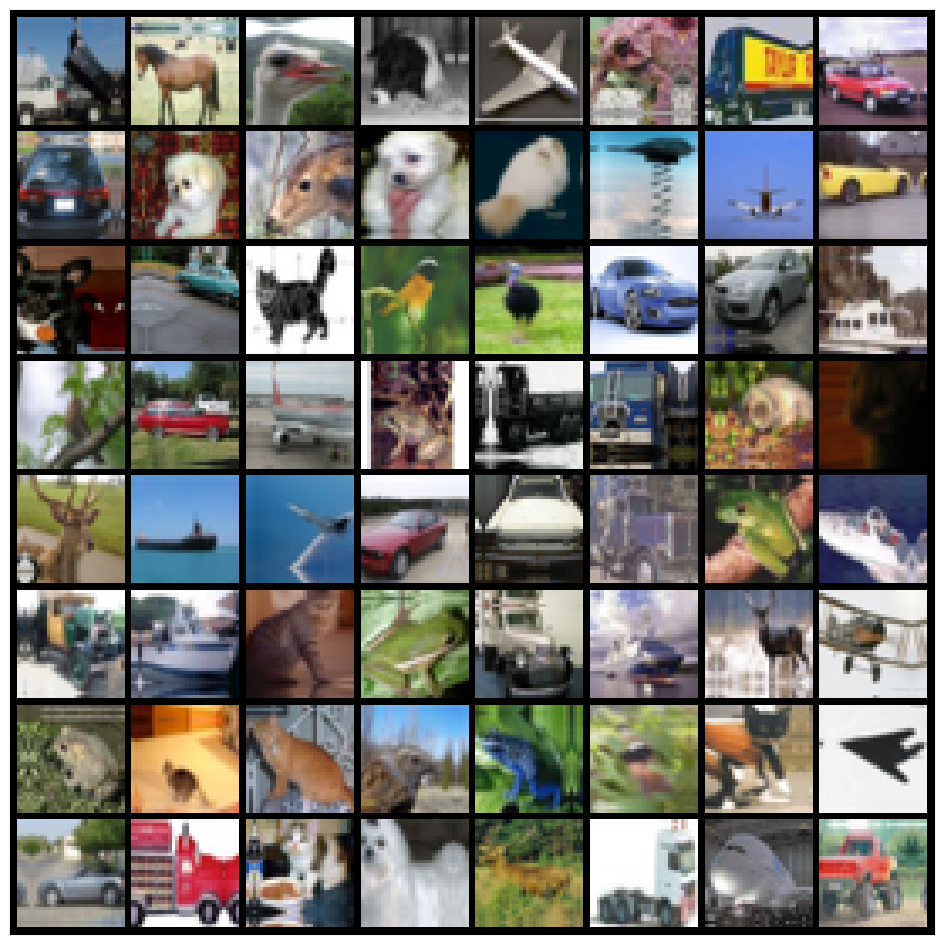

In [ ]:
show_image(train_loader)

# ResNet (Residual Neural Network)

One of the principal modifications incorporated into our CNN model this time revolves around the integration of residual blocks. These blocks entail combining the initial input with the resultant feature map derived from subjecting the input to one or multiple convolutional layers.

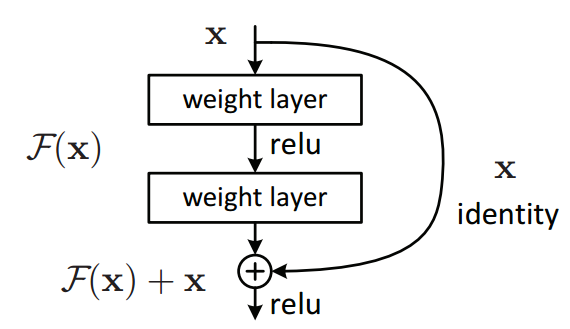

In a ResNet, each layer learns the difference between the input and the desired output. The network then adds this difference to the original input to get the final output of the layer. This addition of the original input acts like a shortcut.

So, by using residual connections, the network can learn faster and more effectively because it's building on what it already knows, rather than starting from scratch at each layer. This makes the learning process smoother and the network more accurate in recognizing the images.

## Simple residual block

In [ ]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)  # 3
    self.relu1= nn.ReLU()
    self.conv2= nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2= nn.ReLU()
    self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(768, 10))

  def forward(self,x):
    out= self.conv1(x)
    out= self.relu1(out)
    out= self.conv2(out)
    out=self.relu2(out)+x
    out= self.classifier(out)

    return out

In [ ]:
simpleModel= SimpleResidualBlock()
simpleModel=simpleModel.to(device)

In [ ]:
simpleModel

SimpleResidualBlock(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (classifier): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=768, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate=0.001
criterion= nn.CrossEntropyLoss()
optimizer=optim.SGD(simpleModel.parameters(), lr=learning_rate)

In [ ]:
#traing model on the train_loader
n_total_steps= len(train_loader)
num_epochs=11
for epoch in range(num_epochs):
    simpleModel.train()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # print(labels.shape)
        #forward pass
        outputs = simpleModel(inputs)

        # print("output : ", outputs.shape)
        loss = criterion(outputs, labels)

        #back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch_idx % 2000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
print("Finished training")


Epoch [1/11], Step [0/500], Loss: 2.6981

Epoch [2/11], Step [0/500], Loss: 2.1180

Epoch [3/11], Step [0/500], Loss: 2.0139

Epoch [4/11], Step [0/500], Loss: 2.0248

Epoch [5/11], Step [0/500], Loss: 1.8310

Epoch [6/11], Step [0/500], Loss: 2.0774

Epoch [7/11], Step [0/500], Loss: 1.9206

Epoch [8/11], Step [0/500], Loss: 1.8668

Epoch [9/11], Step [0/500], Loss: 1.9953

Epoch [10/11], Step [0/500], Loss: 1.9564

Epoch [11/11], Step [0/500], Loss: 2.0714

Finished training


In [ ]:
# Testing loop
with torch.no_grad():
    correct = 0
    total = 0

    n_class_correct=[0 for i in range(10)]
    n_class_samples=[0 for i in range(10)]
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = simpleModel(inputs)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label= labels[i]
            pred= predicted[i]
            if(label==pred):
                n_class_correct[label]+=1
            n_class_samples[label]+=1

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    for i in range(10):
        acc= 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f"Accuracy of the class {classes[i]}:{acc}%")

Test Accuracy: 35.03%

Accuracy of the class plane:44.4%

Accuracy of the class car:39.3%

Accuracy of the class bird:13.0%

Accuracy of the class cat:17.7%

Accuracy of the class deer:26.7%

Accuracy of the class dog:34.4%

Accuracy of the class frog:46.0%

Accuracy of the class horse:35.5%

Accuracy of the class ship:50.9%

Accuracy of the class truck:42.4%


## ResNet9
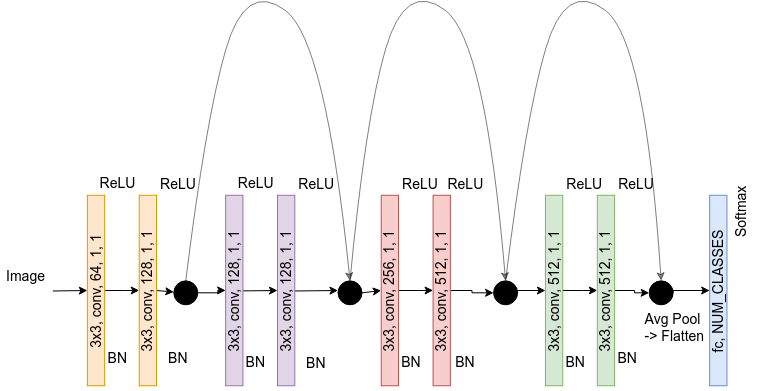

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels= images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels= images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def convBlock(in_channels, out_channels, pool=False):
    layers=[nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# ResNet-9
class ResNet9(ImageClassificationBase):
    def __init__(self,in_channel, num_classes):
        super().__init__()

        self.conv1= convBlock(in_channel, 64)
        self.conv2= convBlock(64,128, pool=True)
        self.res1= nn.Sequential(convBlock(128,128),convBlock(128,128))

        self.conv3= convBlock(128, 256)
        self.conv4= convBlock(256,512, pool=True)
        self.res2= nn.Sequential(convBlock(512,512),convBlock(512,512))

        self.classifier= nn.Sequential(nn.MaxPool2d(4),
                                      nn.Flatten(),
                                      nn.Dropout(0.2), #512 x 2 x 2
                                      nn.Linear(2048,num_classes))

    def forward(self, x):
        out= self.conv1(x)  # 64 x 32 x 32
        out= self.conv2(out) # 128 x 16 x 16
        out= self.res1(out)+out # 128 x 16 x 16
        out= self.conv3(out) # 256 x  16 x 16
        out= self.conv4(out) # 512 x 8 x 8
        out= self.res2(out)+out # 512 x 8 x 8
        out= self.classifier(out) # 10
        return out


In [ ]:
# initiating and moving model to device
model = ResNet9(3,10)
model= model.to(device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training model


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader) # returns a dict
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(model, test_loader)]
history

[{'val_loss': 2.3033177852630615, 'val_acc': 0.09619998931884766}]

In [ ]:
history=[]

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, test_loader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 1.5335, val_loss: 1.2913, val_acc: 0.5824
Epoch [1], last_lr: 0.00760, train_loss: 1.1222, val_loss: 0.9467, val_acc: 0.6808
Epoch [2], last_lr: 0.01000, train_loss: 0.8805, val_loss: 0.8659, val_acc: 0.6960
Epoch [3], last_lr: 0.00950, train_loss: 0.7876, val_loss: 0.8004, val_acc: 0.7426
Epoch [4], last_lr: 0.00812, train_loss: 0.7357, val_loss: 0.7790, val_acc: 0.7419
Epoch [5], last_lr: 0.00611, train_loss: 0.6685, val_loss: 0.6992, val_acc: 0.7632
Epoch [6], last_lr: 0.00389, train_loss: 0.5914, val_loss: 0.5394, val_acc: 0.8200
Epoch [7], last_lr: 0.00188, train_loss: 0.4846, val_loss: 0.4927, val_acc: 0.8321
Epoch [8], last_lr: 0.00050, train_loss: 0.3728, val_loss: 0.3426, val_acc: 0.8832
Epoch [9], last_lr: 0.00000, train_loss: 0.2857, val_loss: 0.3169, val_acc: 0.8929
CPU times: user 6min 49s, sys: 730 ms, total: 6min 49s
Wall time: 6min 51s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

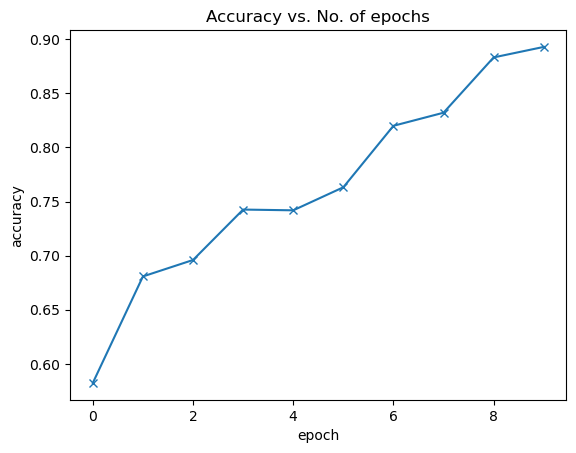

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

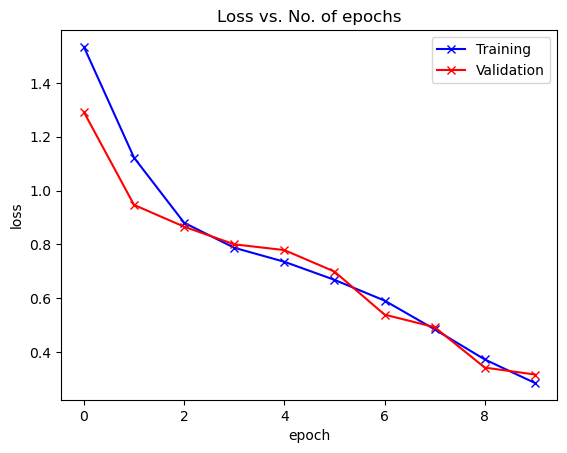

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

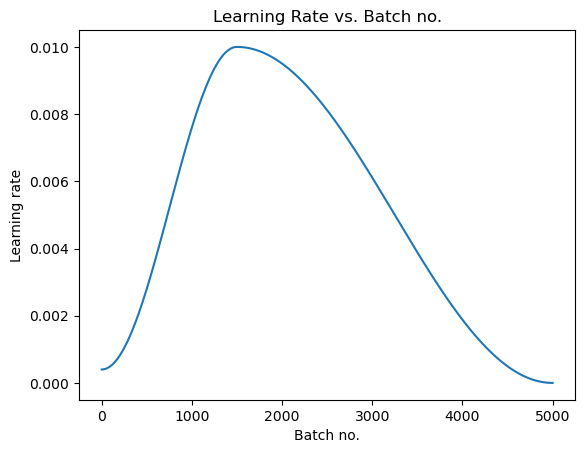

In [ ]:
plot_lrs(history)